In [14]:
from google.colab import files
uploaded = files.upload()

Saving TeamHealthRawData.xlsx to TeamHealthRawData (1).xlsx


In [15]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
import io
df = pd.read_excel(io.BytesIO(uploaded['TeamHealthRawData.xlsx']))
# Dataset is now stored in a Pandas Dataframe

In [17]:
# adding an row_id field to the dataframe, which will be useful for joining later
df["row_id"] = df.index + 1

In [18]:
print (df.head(10))

    Period Manager    Team                                           Response  \
0  2019-Q1   Mgr 1  Team 1  We're a fun team that works well together and ...   
1  2019-Q1   Mgr 1  Team 1  we have a sound and collaborative team focused...   
2  2019-Q1   Mgr 1  Team 1  we work well as a team, we have fun together, ...   
3  2019-Q1   Mgr 1  Team 1  I fell pretty good about the health of our tea...   
4  2019-Q1   Mgr 1  Team 1  happy with team's overall health and good dyna...   
5  2019-Q1   Mgr 1  Team 1                                              Solid   
6  2019-Q1   Mgr 1  Team 1  The Team 2 team is a  collaborative group prod...   
7  2019-Q1   Mgr 1  Team 1  We have great teamwork.  We have a lot of fun....   
8  2019-Q1   Mgr 1  Team 1  We feel good about our teamwork, process, tech...   
9  2019-Q1   Mgr 1  Team 2  A blast!  Always working towards delivering mo...   

   row_id  
0       1  
1       2  
2       3  
3       4  
4       5  
5       6  
6       7  
7       8  


In [19]:
#create a new data frame with "id" and "comment" fields
df_subset = df[['row_id', 'Response']].copy()
#data clean-up
#remove all non-aphabet characters
df_subset['Response'] = df_subset['Response'].str.replace("[^a-zA-Z#]", " ")
#covert to lower-case
df_subset['Response'] = df_subset['Response'].str.casefold()
print (df_subset.head(10))

   row_id                                           Response
0       1  we re a fun team that works well together and ...
1       2  we have a sound and collaborative team focused...
2       3  we work well as a team  we have fun together  ...
3       4  i fell pretty good about the health of our tea...
4       5  happy with team s overall health and good dyna...
5       6                                              solid
6       7  the team   team is a  collaborative group prod...
7       8  we have great teamwork   we have a lot of fun ...
8       9  we feel good about our teamwork  process  tech...
9      10  a blast   always working towards delivering mo...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [20]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [21]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['row_id']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

Processing sentiment analysis...
   row_id sentiment_type  sentiment_score
0       1       compound           0.6597
0       2       compound           0.9287
0       3       compound           0.8122
0       4       compound           0.8225
0       5       compound           0.8271
0       6       compound           0.1531
0       7       compound           0.9382
0       8       compound           0.9381
0       9       compound           0.9468
0      10       compound           0.5059


In [22]:
#merge dataframes
df_output = pd.merge(df, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(10))

    Period Manager    Team                                           Response  \
0  2019-Q1   Mgr 1  Team 1  We're a fun team that works well together and ...   
1  2019-Q1   Mgr 1  Team 1  we have a sound and collaborative team focused...   
2  2019-Q1   Mgr 1  Team 1  we work well as a team, we have fun together, ...   
3  2019-Q1   Mgr 1  Team 1  I fell pretty good about the health of our tea...   
4  2019-Q1   Mgr 1  Team 1  happy with team's overall health and good dyna...   
5  2019-Q1   Mgr 1  Team 1                                              Solid   
6  2019-Q1   Mgr 1  Team 1  The Team 2 team is a  collaborative group prod...   
7  2019-Q1   Mgr 1  Team 1  We have great teamwork.  We have a lot of fun....   
8  2019-Q1   Mgr 1  Team 1  We feel good about our teamwork, process, tech...   
9  2019-Q1   Mgr 1  Team 2  A blast!  Always working towards delivering mo...   

   row_id sentiment_type  sentiment_score  
0       1       compound           0.6597  
1       2       comp

# Visualize sentiment analysis output

In [23]:
#This section will demonstrate how to analyze, visualize, and interpret the sentiment scores generated by the previous steps.
df_output[["sentiment_score"]].describe()


,sentiment_score
count,300.000000
mean,0.594633
std,0.376298
min,-0.895700
25%,0.440400
50%,0.715900
75%,0.865800
max,0.988300


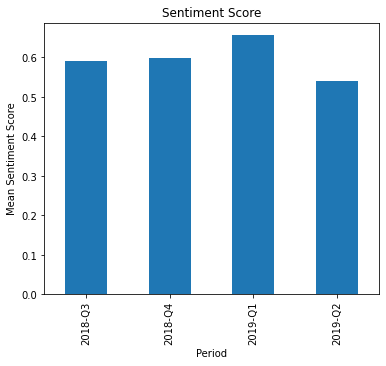

In [24]:
#generate mean of sentiment_score by period
dfg = df_output.groupby(['Period'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(6, 5))

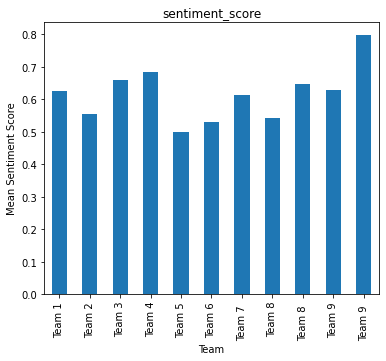

In [25]:
dfg = df_output.groupby(['Team'])['sentiment_score'].mean()
dfg.plot(kind='bar', title='sentiment_score', ylabel='Mean Sentiment Score',
         xlabel='Team', figsize=(6, 5))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

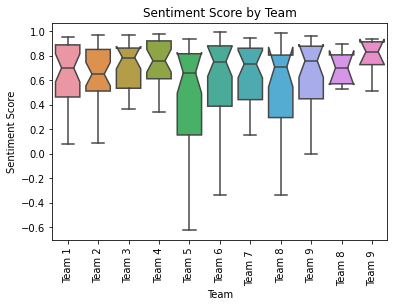

In [26]:
import seaborn as sns
#create seaborn boxplots by group
sns.boxplot(x='Team', y='sentiment_score', notch = True,
            data=df_output, showfliers=False).set(title='Sentiment Score by Team')
#modify axis labels
plt.xlabel('Team')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)